# 1.import library

In [8]:
import cv2
import gc
import io
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tempfile
import threading
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn.metrics import (roc_curve, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.notebook import tqdm
from transformers import WhisperModel, WhisperProcessor, WhisperConfig, Trainer, TrainingArguments, PreTrainedModel, \
    AutoConfig

# 2.CsvLoader

In [9]:
class CsvLoader:
    def __init__(self, max_workers=96):
        self.max_workers = max_workers

    def load_audio_info_from_csv(self, csv_file, allowed_set=None, allowed_data_source="all"):
        df = pd.read_csv(csv_file)

        df = df[df["absolute_path"].apply(os.path.exists)]

        if allowed_set is not None:
            df = df[df["Set"].isin(allowed_set)]
        if allowed_data_source != "all":
            df = df[df["data_source"].isin(allowed_data_source)]

        # 内部函数：从一行数据中提取所需信息
        def load_info(row):
            abs_path = row["absolute_path"]
            speaker = row["speaker"]
            label = int(row["label"])  # 转换为 int 类型
            return (abs_path, speaker, label)

        records = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            # 提交任务
            futures = {executor.submit(load_info, row): idx for idx, row in df.iterrows()}
            # 利用 tqdm 显示进度条
            for future in tqdm(as_completed(futures), total=len(futures), desc="Loading audio info from CSV"):
                result = future.result()
                if result is not None:
                    records.append(result)
        return records

# 3.audio-Augmentation

In [10]:
from torch.nn.utils.rnn import pad_sequence


def random_noise(audio, noise_factor=0.005):
    """给音频添加随机噪声"""
    noise = torch.randn_like(audio) * noise_factor
    return audio + noise


def random_timeshift(audio, max_shift=16000):
    """对音频进行随机时间偏移"""
    shift = random.randint(-max_shift, max_shift)
    if shift > 0:
        audio = audio[shift:]  # 向后偏移
        audio = F.pad(audio, (0, shift))  # 填充前部
    elif shift < 0:
        audio = audio[:shift]  # 向前偏移
        audio = F.pad(audio, (-shift, 0))  # 填充后部
    return audio


def random_crop_or_pad(audio, target_length=160000, pad_value=0):
    """随机裁剪或填充音频到固定长度"""
    audio_len = audio.shape[0]
    if audio_len < target_length:
        pad_amount = target_length - audio_len
        audio = F.pad(audio, (0, pad_amount), value=pad_value)
    elif audio_len > target_length:
        start_idx = random.randint(0, audio_len - target_length)
        audio = audio[start_idx:start_idx + target_length]
    return audio


# def audio_trim(audio, threshold=0.01):
#     """修剪音频的静默部分"""
#     non_zero_indices = torch.nonzero(torch.abs(audio) > threshold).squeeze()
#     if non_zero_indices.numel() > 0:
#         # 将 Tensor 转为 int 后再切片
#         start = int(non_zero_indices[0].item())
#         end   = int(non_zero_indices[-1].item()) + 1
#         return audio[start:end]
#     return audio

# ---------------------------
# CutMix 实现
# ---------------------------
def cutmix_3d(x, y, beta=1.0, cutmix_prob=0.2):
    """
    对3维谱图做 CutMix：
    x: [B, T, F]
    y: [B]
    """
    if random.random() < cutmix_prob:
        lam = np.random.beta(beta, beta)
        B, T, F = x.shape
        # 随机打乱
        rand_index = torch.randperm(B)

        # 随机生成切块区域
        cx = np.random.randint(F)
        cy = np.random.randint(T)
        cut_w = int(F * np.sqrt(1 - lam))
        cut_h = int(T * np.sqrt(1 - lam))
        x1 = np.clip(cx - cut_w // 2, 0, F)
        y1 = np.clip(cy - cut_h // 2, 0, T)
        x2 = np.clip(cx + cut_w // 2, 0, F)
        y2 = np.clip(cy + cut_h // 2, 0, T)

        # 应用 CutMix
        x[:, y1:y2, x1:x2] = x[rand_index, y1:y2, x1:x2]

        # 重算 lambda
        lam = 1 - ((x2 - x1) * (y2 - y1) / (T * F))

        return x, y, y[rand_index], lam
    else:
        return x, y, None, None


# ---------------------------
# MixUp 实现
# ---------------------------
def mixup_data(x, y, alpha=1.0, mixup_prob=0.2):
    """
    通用 MixUp：
      x: Tensor，形状 [B, ...]，任意除 batch 以外多维
      y: Tensor，[B] 的标签
    返回:
      mixed_x: 混合后的特征，形状同 x
      y_a, y_b: 原标签和打乱后标签
      lam: 混合系数（None 表示未应用 MixUp）
    """
    if random.random() < mixup_prob:
        lam = np.random.beta(alpha, alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size)
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    else:
        return x, y, None, None


# ---------------------------
# 自定义 collate 函数，结合 CutMix 和 MixUp 增强技术
# ---------------------------average_precision_score
def custom_collate_fn(batch, cutmix_prob=0.1, mixup_prob=0.1):
    features, speakers, labels = zip(*batch)
    # [B, T, F]
    features = torch.stack(features, dim=0)
    labels = torch.tensor([int(l) for l in labels], dtype=torch.long)

    aug = random.choice(['cutmix', 'mixup', 'none'])
    if aug == 'cutmix':
        feats_cm, y_a, y_b, lam = cutmix_3d(features, labels, beta=1.0, cutmix_prob=cutmix_prob)
        return feats_cm, speakers, (y_a, y_b, lam)
    elif aug == 'mixup':
        feats_mu, y_a, y_b, lam = mixup_data(features, labels, alpha=1.0, mixup_prob=mixup_prob)
        return feats_mu, speakers, (y_a, y_b, lam)
    else:
        return features, speakers, labels

# 4.AudioDataset

In [11]:
class AudioDataset(Dataset):
    def __init__(
            self,
            records,
            noise_prob=0.1,
            timeshift_prob=0.1,
            crop_or_pad_prob=0.1,
            trim_prob=0.1,
    ):
        self.records = records
        self.processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
        config = AutoConfig.from_pretrained("openai/whisper-tiny.en")
        self.target_length = config.max_source_positions  # e.g., 3000
        # augmentation probabilities
        self.noise_prob = noise_prob
        self.timeshift_prob = timeshift_prob
        self.crop_or_pad_prob = crop_or_pad_prob
        self.trim_prob = trim_prob
        self.lock = threading.Lock()
        self.cache = {}

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        # 记录格式：(wav_path, speaker, label)
        wav_path, speaker, label = self.records[idx]

        with self.lock:
            if wav_path in self.cache:
                return self.cache[wav_path]
        audio_np, sr = librosa.load(wav_path, sr=16000)

        # audio = torch.from_numpy(audio_np)
        # # audio-level augmentations before feature extraction
        # if random.random() < self.noise_prob:
        #     audio = random_noise(audio)
        # if random.random() < self.timeshift_prob:
        #     audio = random_timeshift(audio)
        # if random.random() < self.crop_or_pad_prob:
        #     audio = random_crop_or_pad(audio, int(16000 * 10))
        # audio_np = audio.numpy() 

        inputs = self.processor(audio_np, sampling_rate=sr, return_tensors="pt", padding="max_length",
                                max_length=16000 * 30)
        audio_feats = inputs.input_features.squeeze(0)  # [80, 3000]

        # pad/truncate to fixed length
        # seq_len = audio_feats.size(0)
        # if seq_len < self.target_length:
        #     pad_amt = self.target_length - seq_len
        #     audio_feats = F.pad(audio_feats, (0, 0, 0, pad_amt))
        # else:
        #     audio_feats = audio_feats[: self.target_length]

        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        item = (audio_feats, speaker, label_tensor)
        with self.lock:
            self.cache[wav_path] = item
        return item

    def get_group_splits(self, n_splits=5):
        indices = np.arange(len(self.records))
        groups = [record[1] for record in self.records]  # 根据 speaker 分组
        gkf = GroupKFold(n_splits=n_splits)
        splits = list(gkf.split(indices, groups=groups))
        return splits

# 5.Build Wav2Vec2Classifier

In [12]:
class WhisperEncoderForBinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()
        # this line for pretained whisper
        self.encoder = WhisperModel.from_pretrained("openai/whisper-tiny.en").encoder

        # this two lines for training from scratch
        # configuration = WhisperConfig()
        # self.encoder = WhisperModel(configuration).encoder

        self.fc = nn.Linear(self.encoder.config.hidden_size, 1)  # 二分类

    def forward(self, input_features):
        encoder_outputs = self.encoder(input_features).last_hidden_state
        pooled_output = encoder_outputs.mean(dim=1)  # 简单的池化操作，取平均值
        logits = self.fc(pooled_output)
        x = torch.sigmoid(logits)
        return x


In [13]:
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 6.WavLMTrainer

In [14]:
class whisperTrainer:
    def __init__(self, train_dataloader: DataLoader, val_dataloader: DataLoader, device=None,
                 lr=0.0001, patience=5, lr_gamma=0.9,
                 checkpoint_path="Whisper_best.pt", project_name="Whisper_Project",
                 freeze_encoder=False, num_classes=1):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.checkpoint_path = checkpoint_path
        self.patience = patience

        # 使用 WhisperEncoderForBinaryClassification 模型
        self.model = WhisperEncoderForBinaryClassification().to(self.device)
        if freeze_encoder:
            for p in self.model.encoder.parameters():
                p.requires_grad = False

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Set up the ExponentialLR scheduler
        self.scheduler = ExponentialLR(self.optimizer, gamma=lr_gamma)

        # 初始化 wandb
        wandb.init(project=project_name)
        wandb.watch(self.model, log="all")

        # Variables for early stopping
        self.best_val_loss = float('inf')
        self.no_improve_count = 0

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)
        for features, speakers, labels in progress_bar:
            features = features.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(features).squeeze(1)  # outputs shape: (B,)

            # 判断是否应用了增强
            if isinstance(labels, tuple):
                # labels 为 (y_a, y_b, lam)
                y_a, y_b, lam = labels
                # 如果增强结果未真正应用（例如 y_b is None），则直接使用 y_a 作为标签
                if y_b is None:
                    labels_tensor = y_a.to(self.device).float()
                    loss = self.criterion(outputs, labels_tensor)
                    preds = (torch.sigmoid(outputs) >= 0.5).long()
                    batch_correct = (preds == labels_tensor.long()).sum().item()
                    batch_size = labels_tensor.size(0)
                else:
                    y_a = y_a.to(self.device).float()
                    y_b = y_b.to(self.device).float()
                    loss = lam * self.criterion(outputs, y_a) + (1 - lam) * self.criterion(outputs, y_b)
                    # 对于准确率这里简单使用 y_a 作为参考
                    preds = (torch.sigmoid(outputs) >= 0.5).long()
                    batch_correct = (preds == y_a.long()).sum().item()
                    batch_size = y_a.size(0)
            else:
                labels = labels.to(self.device).float()
                loss = self.criterion(outputs, labels)
                preds = (torch.sigmoid(outputs) >= 0.5).long()
                batch_correct = (preds == labels.long()).sum().item()
                batch_size = labels.size(0)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * batch_size
            running_correct += batch_correct
            total_samples += batch_size
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        return epoch_loss, epoch_acc

    def validate_one_epoch(self):
        if self.val_dataloader is None:
            return None, None

        self.model.eval()
        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        progress_bar = tqdm(self.val_dataloader, desc="Validating", leave=False)
        with torch.no_grad():
            for features, speakers, labels in progress_bar:
                features = features.to(self.device)
                # 方法2：在验证中判断 labels 是否为 tuple，若是，则直接取 y_a 作为标签
                if isinstance(labels, tuple):
                    y_a, _, _ = labels
                    labels_tensor = y_a.to(self.device).float()
                else:
                    labels_tensor = labels.to(self.device).float()

                outputs = self.model(features).squeeze(1)
                loss = self.criterion(outputs, labels_tensor)
                running_loss += loss.item() * labels_tensor.size(0)

                preds = (torch.sigmoid(outputs) >= 0.5).long()
                running_correct += (preds == labels_tensor.long()).sum().item()
                total_samples += labels_tensor.size(0)
                progress_bar.set_postfix(loss=loss.item())

        val_loss = running_loss / total_samples
        val_acc = running_correct / total_samples
        return val_loss, val_acc

    def save_model(self, filepath):
        """保存当前模型参数到指定文件"""
        torch.save(self.model.state_dict(), filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """加载模型参数"""
        self.model.load_state_dict(torch.load(filepath, map_location=self.device))
        self.model.to(self.device)
        print(f"Model loaded from {filepath}")

    def predict(self, test_dataloader):
        """
        对测试数据进行预测，返回预测结果列表
        """
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for features, _, _ in test_dataloader:
                features = features.to(self.device)
                outputs = self.model(features).squeeze(1)
                preds = (torch.sigmoid(outputs) >= 0.5).long().cpu().numpy()
                predictions.extend(preds)
        return predictions

    def fit(self, num_epochs=20):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_one_epoch()
            val_loss, val_acc = self.validate_one_epoch()

            if val_loss is not None:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

            # 若验证 loss 改进，则保存最佳模型，并重置未改进计数器；否则累计未改进轮数
            if val_loss is not None:
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.no_improve_count = 0
                    self.save_model(self.checkpoint_path)
                else:
                    self.no_improve_count += 1
                    print(f"No improvement count: {self.no_improve_count}/{self.patience}")
                    if self.no_improve_count >= self.patience:
                        print("Early stopping triggered.")
                        break

            log_dict = {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "epoch": epoch + 1
            }
            if val_loss is not None:
                log_dict["val_loss"] = val_loss
                log_dict["val_acc"] = val_acc

            wandb.log(log_dict)


# 7.DataModule

In [15]:
class DataModule:
    """
    封装数据加载流程，包括：
      1. 从 CSV 加载 wav 文件路径及元数据；
      2. 构建 AudioDataset（直接加载文件，包含缓存与按需加载）；
      3. 根据 speaker 使用 GroupKFold 划分子集；
      4. 构造 train 和 valid DataLoader，并在 collate_fn 中使用增强技术。
    """

    def __init__(self, csv_file, allowed_set, allowed_data_source="all",
                 batch_size=128, num_workers_csv=128, num_workers_dataset=0, n_splits=5):
        self.csv_file = csv_file
        self.allowed_set = allowed_set
        self.allowed_data_source = allowed_data_source
        self.batch_size = batch_size
        self.num_workers_csv = num_workers_csv
        self.num_workers_dataset = num_workers_dataset
        self.n_splits = n_splits
        self.train_loader = None
        self.valid_loader = None
        self.dataset = None

    def setup(self):
        def my_collate_fn(batch):
            return custom_collate_fn(batch, cutmix_prob=0.5, mixup_prob=0.5)

        # 1. 从 CSV 加载 wav 文件路径及元数据
        loader = CsvLoader(max_workers=self.num_workers_csv)
        records = loader.load_audio_info_from_csv(
            csv_file=self.csv_file,
            allowed_set=self.allowed_set,
            allowed_data_source=self.allowed_data_source
        )

        # 2. 构建 AudioDataset（直接加载文件，包含缓存与按需加载）
        self.dataset = AudioDataset(
            records=records
        )

        # 3. 使用 GroupKFold 根据 speaker 划分数据集
        splits = self.dataset.get_group_splits(n_splits=self.n_splits)
        train_idx, valid_idx = splits[0]
        train_subset = Subset(self.dataset, train_idx)
        valid_subset = Subset(self.dataset, valid_idx)

        # 4. 创建 DataLoader，使用自定义 collate_fn（集成增强）
        self.train_loader = DataLoader(
            train_subset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers_dataset,
            collate_fn=my_collate_fn
        )
        self.valid_loader = DataLoader(
            valid_subset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers_dataset,
            collate_fn=my_collate_fn
        )

    def get_loaders(self):
        if self.train_loader is None or self.valid_loader is None:
            self.setup()
        return self.train_loader, self.valid_loader


In [17]:
# Initialize the DataModule
data_module = DataModule(
    csv_file="/home/jupyter/Data/meta_final.csv",  # Meta file path
    allowed_set=['train'],  # Specify which subset to use (train or test)
    allowed_data_source="all",  # Specify data sources to include ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based']
    batch_size=64,  # Batch size for training
    num_workers_csv=128,  # Number of workers for CSV loading
    num_workers_dataset=4  # Number of workers for dataset loading (use a reasonable value based on your system)
)

# Setup the data module (loads data and initializes dataloaders)
data_module.setup()

# Retrieve the training and validation dataloaders
train_loader, valid_loader = data_module.get_loaders()

# Checking the first batch from the train_loader
for batch in train_loader:
    features, speakers, labels = batch
    print(f"Feature Shape: {features.shape}, Labels Shape: {len(speakers)}, Speakers: {len(speakers)}")
    break  # Print the first batch and break

Loading audio info from CSV:   0%|          | 0/368706 [00:00<?, ?it/s]

Feature Shape: torch.Size([64, 80, 3000]), Labels Shape: 64, Speakers: 64


In [ ]:
trainer = whisperTrainer(
    train_dataloader=train_loader,
    val_dataloader=valid_loader,
    device=device,
    lr=0.0001,
    patience=5,
    lr_gamma=0.95,
    checkpoint_path="whisper_pretrained_v1.pt",
    project_name="whisper_pretrained_v1",
    freeze_encoder=True
)

# 开始训练
trainer.fit(num_epochs=50)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zlj201900820209 (zlj201900820209-national-university-of-singapore-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training:   0%|          | 0/4609 [00:00<?, ?it/s]

# 8.Batch predict

In [1]:
# ---------------------------
# 简单的 collate_fn（预测时不需要数据增强）
# ---------------------------
def simple_collate_fn(batch):
    features, speakers, labels = zip(*batch)
    features = torch.stack(features, dim=0)
    labels = torch.tensor([int(l) for l in labels], dtype=torch.long)
    return features, speakers, labels


# ---------------------------
# PredictDataModule: 用于加载预测数据的 DataModule
# ---------------------------
class PredictDataModule:
    """
    封装预测数据加载流程，包括：
      1. 从 CSV 加载 npy 文件路径及元数据；
      2. 构建 MFCCDataset（直接加载 npy 文件，包含缓存）；
      3. 构造预测用的 DataLoader（不应用数据增强）。
    """

    def __init__(self, csv_file, allowed_set=None, allowed_data_source="all",
                 batch_size=256, num_workers_csv=96, num_workers_dataset=0):
        self.csv_file = csv_file
        self.allowed_set = allowed_set  # 预测时可不过滤
        self.allowed_data_source = allowed_data_source
        self.batch_size = batch_size
        self.num_workers_csv = num_workers_csv
        self.num_workers_dataset = num_workers_dataset

        self.predict_loader = None
        self.dataset = None

    def setup(self):
        # 1. 从 CSV 加载 npy 文件路径及元数据
        npy_loader = NpyLoader(max_workers=self.num_workers_csv)
        records = npy_loader.load_audio_info_from_csv(
            csv_file=self.csv_file,
            allowed_set=self.allowed_set,
            allowed_data_source=self.allowed_data_source
        )
        # 2. 构建 MFCCDataset（预测时不应用数据增强，将 spec_aug_prob 设置为 0）
        self.dataset = MFCCDataset(
            records=records,
            spec_aug_prob=0.0
        )
        # 3. 创建 DataLoader
        self.predict_loader = DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers_dataset,
            collate_fn=simple_collate_fn
        )

    def get_loader(self):
        if self.predict_loader is None:
            self.setup()
        return self.predict_loader

In [2]:
class ModelEvaluation:
    def __init__(self, model, device, predict_loader, weight_path, threshold=0.5):
        """
        :param model: 预定义的模型（例如 Conformer），需要与权重匹配
        :param device: 设备
        :param predict_loader: 用于预测的 DataLoader（返回 (features, speakers, labels)）
        :param weight_path: 模型权重路径
        :param threshold: 预测阈值
        """
        self.model = model.to(device)
        self.device = device
        self.predict_loader = predict_loader
        self.weight_path = weight_path
        self.threshold = threshold

        # 预测结果记录
        self.all_probs = []  # 模型预测概率（float）
        self.all_preds = []  # 模型预测标签（int）
        self.all_labels = []  # 真实标签
        self.all_speakers = []  # 对应 speaker

    def load_model(self):
        """加载模型权重"""
        self.model.load_state_dict(torch.load(self.weight_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        print(f"Model loaded from {self.weight_path}")

    def predict(self):
        """使用 predict_loader 批量预测，记录预测概率、预测标签、真实标签和 speaker"""
        self.model.eval()
        with torch.no_grad():
            for features, speakers, labels in tqdm(self.predict_loader, desc="Predicting", leave=False):
                features = features.to(self.device)
                outputs = self.model(features).squeeze(1)  # 输出为 logits
                probs = torch.sigmoid(outputs).cpu().numpy()  # 计算概率
                preds = (probs >= self.threshold).astype(int)
                self.all_probs.extend(probs.tolist())
                # 如果 labels 为 tuple (增强情况)，取第一个作为真实标签
                if isinstance(labels, tuple):
                    y_a = labels[0].numpy()
                    self.all_labels.extend(y_a.tolist())
                else:
                    self.all_labels.extend(labels.cpu().numpy().tolist())
                self.all_preds.extend(preds.tolist())
                self.all_speakers.extend(speakers)
        print("Prediction completed.")

    def compute_eer(self):
        """
        计算 EER（Equal Error Rate）。
        如果 y_true 中只有一个类别，则打印警告并返回 NaN。
        """
        y_true = np.array(self.all_labels)
        if np.unique(y_true).size < 2:
            print("Warning: Only one class present in y_true. EER is not defined.")
            return np.nan
        # 计算 ROC 曲线
        fpr, tpr, _ = roc_curve(y_true, self.all_probs)
        fnr = 1 - tpr
        abs_diffs = np.abs(fpr - fnr)
        if np.isnan(abs_diffs).all():
            eer = np.nan
        else:
            idx_eer = np.nanargmin(abs_diffs)
            eer = fpr[idx_eer]
        return eer

    def evaluate(self):
        """
        计算并打印各项指标：precision, recall, accuracy, f1, AUC, average precision, EER, 混淆矩阵
        并绘制 ROC 与 PR 曲线。
        如果 y_true 只有一个类别，则 ROC AUC、EER 等指标将返回 NaN，并打印警告。
        """
        y_true = np.array(self.all_labels)
        y_pred = np.array(self.all_preds)
        y_prob = np.array(self.all_probs)

        if np.unique(y_true).size < 2:
            print("Warning: Only one class present in y_true. Some metrics (ROC AUC, EER) will be set to NaN.")
            auc = np.nan
            avg_precision = np.nan
            eer = np.nan
        else:
            auc = roc_auc_score(y_true, y_prob)
            avg_precision = average_precision_score(y_true, y_prob)
            eer = self.compute_eer()

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

        print("Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC Score: {auc if not np.isnan(auc) else 'NaN'}")
        print(f"Average Precision: {avg_precision if not np.isnan(avg_precision) else 'NaN'}")
        print(f"EER: {eer if not np.isnan(eer) else 'NaN'}")
        print("Confusion Matrix:")
        print(cm)

        # 绘制 ROC 和 PR 曲线，仅在存在两个类别时
        if np.unique(y_true).size >= 2:
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend(loc="lower right")
            plt.show()

            precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(recall_vals, precision_vals, label=f'PR curve (AP = {avg_precision:.2f})')
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend(loc="lower left")
            plt.show()

    def per_speaker_errors(self):
        """
        统计不同 speaker 的误分类数和总数。
        返回一个字典：{ speaker: (misclassified_count, total_count) }
        """
        speaker_stats = {}
        for speaker, true, pred in zip(self.all_speakers, self.all_labels, self.all_preds):
            if speaker not in speaker_stats:
                speaker_stats[speaker] = [0, 0]  # [error_count, total_count]
            speaker_stats[speaker][1] += 1
            if true != pred:
                speaker_stats[speaker][0] += 1
        return speaker_stats

    def plot_per_speaker_errors(self):
        """
        绘制不同 speaker 的误分类率条形图。
        """
        stats = self.per_speaker_errors()
        speakers = list(stats.keys())
        errors = [stats[s][0] for s in speakers]
        totals = [stats[s][1] for s in speakers]
        error_rates = [e / t if t > 0 else 0 for e, t in zip(errors, totals)]

        plt.figure(figsize=(12, 6))
        plt.bar(speakers, error_rates)
        plt.xlabel("Speaker")
        plt.ylabel("Error Rate")
        plt.title("Error Rate per Speaker")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [3]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source='all',  # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based']
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

NameError: name 'NpyLoader' is not defined

In [27]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source=["diffusion-based"],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.9)
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/39300 [00:00<?, ?it/s]

Predicting:   0%|          | 0/308 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9882
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[38837   463]
 [    0     0]]


In [30]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source=["vox"],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/30315 [00:00<?, ?it/s]

Predicting:   0%|          | 0/237 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[30315]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Loading audio info from CSV:   0%|          | 0/15774 [00:00<?, ?it/s]

Predicting:   0%|          | 0/124 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9434
Precision: 0.9138
Recall: 0.9942
F1 Score: 0.9523
AUC Score: 0.9728220342863357
Average Precision: 0.962210360489073
EER: 0.05683653987369658
Confusion Matrix:
[[5968  841]
 [  52 8913]]


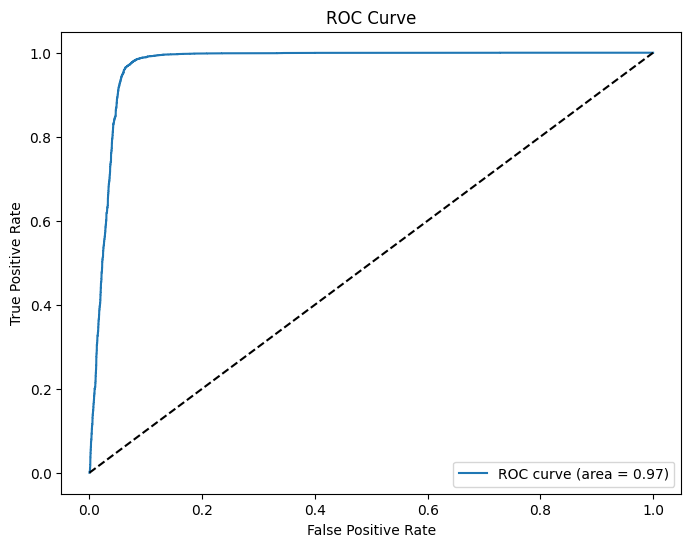

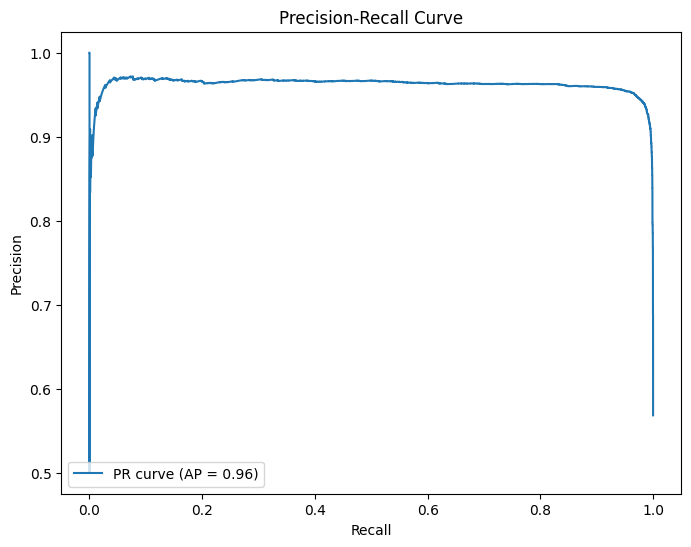

In [31]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source=["itw"],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

In [96]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source=["gen"],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/26200 [00:00<?, ?it/s]

Predicting:   0%|          | 0/205 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9045
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[23698  2502]
 [    0     0]]


Loading audio info from CSV:   0%|          | 0/19409 [00:00<?, ?it/s]

Predicting:   0%|          | 0/152 [00:00<?, ?it/s]

Prediction completed.
Error computing EER: The function value at x=0.0 is NaN; solver cannot continue.
Evaluation Metrics:
Accuracy: 0.9981
Precision: 0.9976
Recall: 0.9976
F1 Score: 0.9976
AUC Score: 0.9999784923216798
Average Precision: 0.999964338206198
EER: NaN
Confusion Matrix:
[[12044    18]
 [   18  7329]]


/opt/conda/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/opt/conda/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


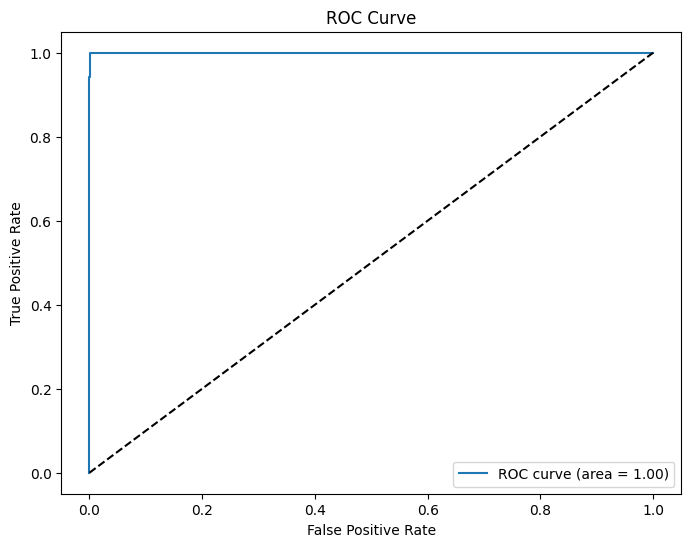

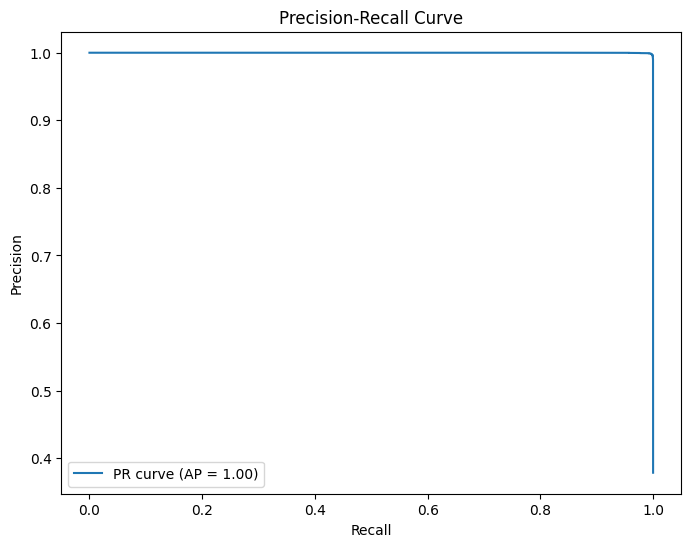

In [97]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source='all',
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9900
Precision: 0.9852
Recall: 1.0000
F1 Score: 0.9925
AUC Score: 0.9938208394119628
Average Precision: 0.9951604689208511
EER: 0.018656716417910446
Confusion Matrix:
[[260   8]
 [  0 532]]


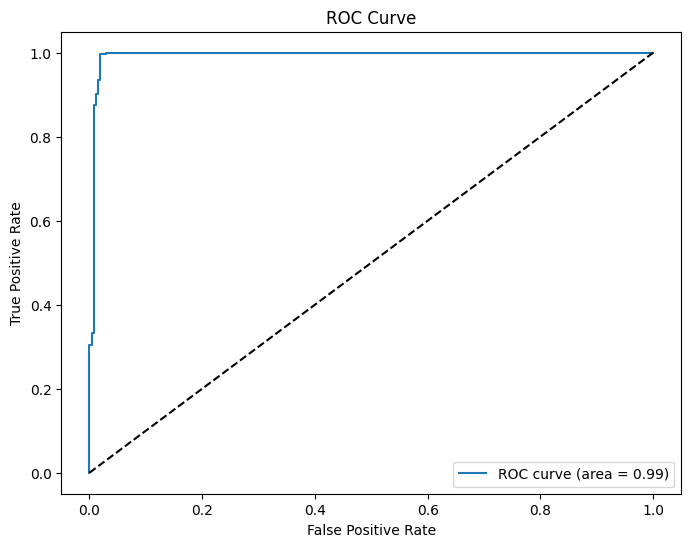

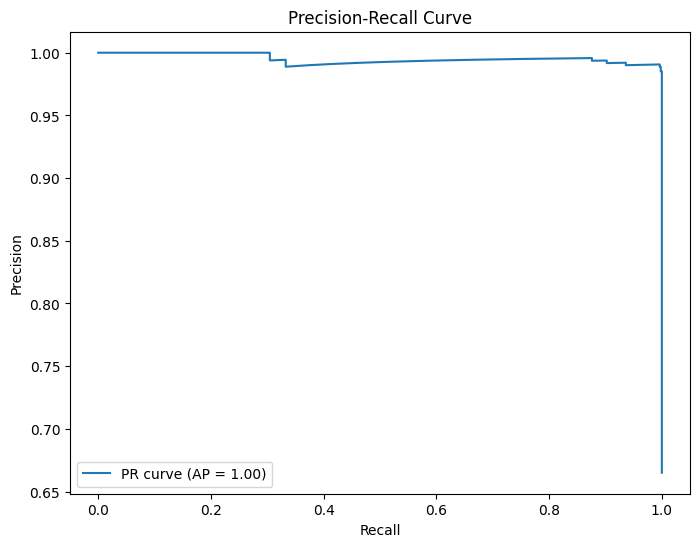

In [33]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source=['itw'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

In [34]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source=['gen'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/4589 [00:00<?, ?it/s]

Predicting:   0%|          | 0/36 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9950
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[4566   23]
 [   0    0]]


In [35]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source=['diffusion-based'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/7205 [00:00<?, ?it/s]

Predicting:   0%|          | 0/57 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[7205]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [36]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source=['LJSpeech'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/655 [00:00<?, ?it/s]

Predicting:   0%|          | 0/6 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9832
Precision: 1.0000
Recall: 0.9832
F1 Score: 0.9915
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[  0   0]
 [ 11 644]]


In [37]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source=['vox'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="whisper_pretrained_v1.pt",
                            threshold=0.5)
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/6160 [00:00<?, ?it/s]

Predicting:   0%|          | 0/49 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[6160]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
